In [37]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [38]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


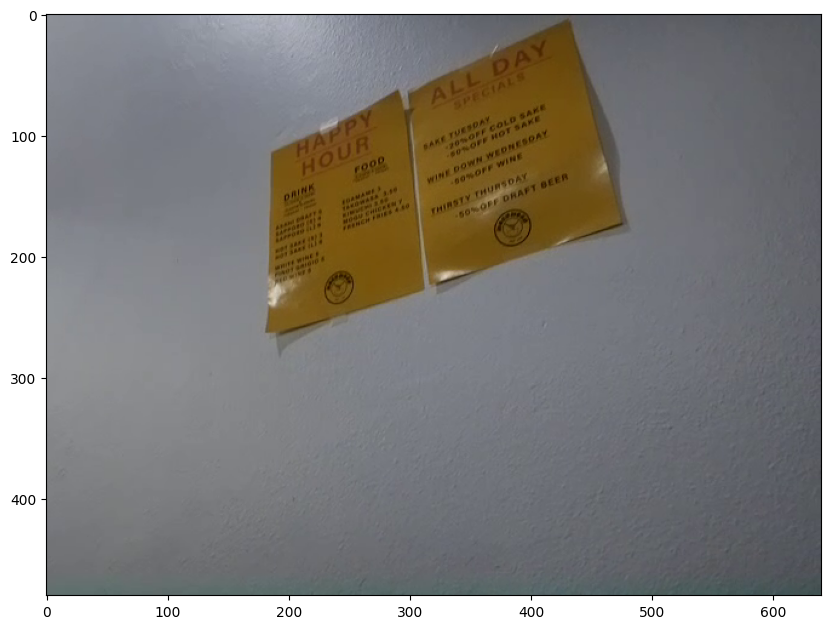

In [39]:
image = cv2.imread('images/restraunt/frame_0014.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [40]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
import onnxruntime

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
ort_session = onnxruntime.InferenceSession('sam.onnx')

predictor = SamPredictor(sam)

In [41]:
predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()

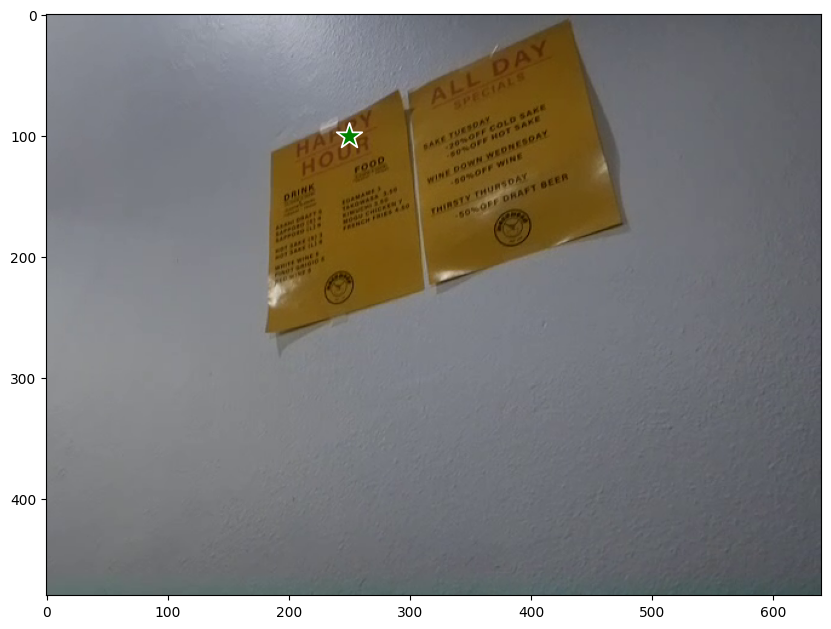

In [42]:
input_point = np.array([[250, 100]])
input_label = np.array([1])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [43]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

In [44]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

In [45]:
masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

In [46]:
masks.shape

(1, 4, 480, 640)

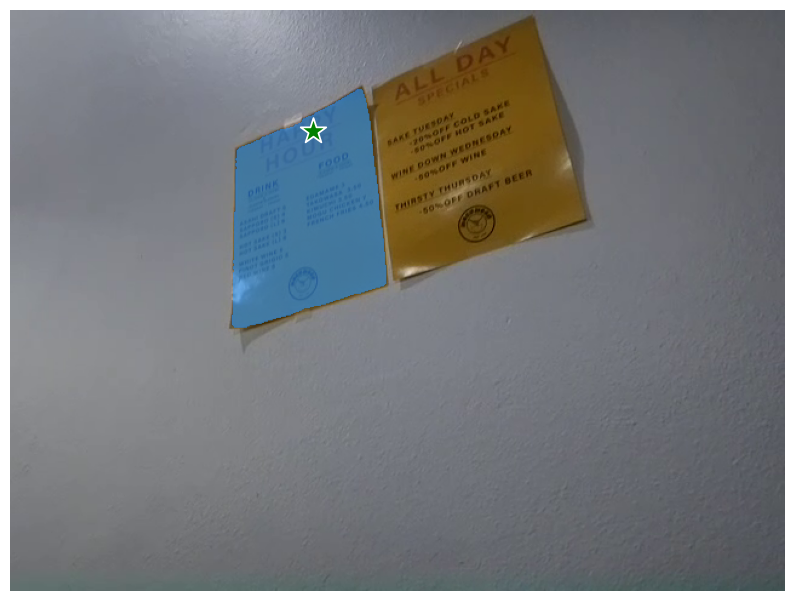

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[0][0], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

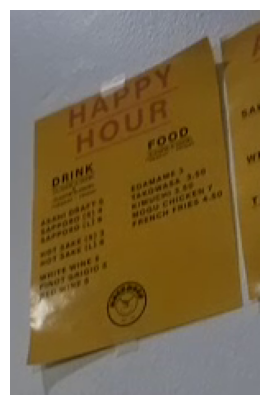

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
best_mask = masks[0][0]
# Convert the mask to uint8 format
mask_uint8 = (best_mask * 255).astype(np.uint8)

# Find contours in the mask
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Image dimensions
img_height, img_width = image.shape[:2]

for contour in contours:
    # Compute the bounding box for the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate padding (10% of the bounding box size)
    pad_w = int(0.1 * w)
    pad_h = int(0.1 * h)
    
    # Apply padding to the bounding box coordinates
    # Make sure the coordinates do not go out of image bounds
    x_pad = max(x - pad_w, 0)
    y_pad = max(y - pad_h, 0)
    w_pad = w + 2 * pad_w
    h_pad = h + 2 * pad_h
    
    # Adjust width and height to not exceed image bounds
    if x_pad + w_pad > img_width:
        w_pad = img_width - x_pad
    if y_pad + h_pad > img_height:
        h_pad = img_height - y_pad
    
    # Extract the padded area
    extracted_image_with_padding = image[y_pad:y_pad+h_pad, x_pad:x_pad+w_pad]
    
    # Display the extracted area with padding
    plt.figure(figsize=(5,5))
    plt.imshow(extracted_image_with_padding)
    plt.axis('off')
    plt.show()
    
    # cv2.imwrite(f'extracted_padded_{i+1}.png', cv2.cvtColor(extracted_image_with_padding, cv2.COLOR_RGB2BGR))
